356.5283394706603


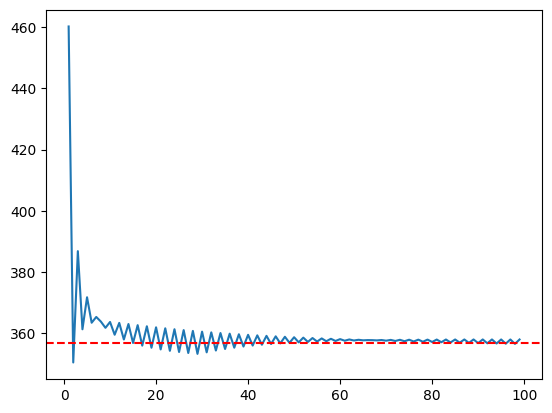

In [ ]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def BLScall(S,K,T,r,vol):
  d1 = (math.log(S/K)+(r+vol*vol/2)*T)/(vol*math.sqrt(T))
  d2 = d1-vol*math.sqrt(T)
  call = S*norm.cdf(d1)-K*math.exp(-r*T)*norm.cdf(d2)
  return call

def bitcall(S0,K,T,r,vol,n):
  dt = T/n
  u = math.exp(vol*math.sqrt(dt))
  d = math.exp(-vol*math.sqrt(dt))
  p = (math.exp(r*dt)-d)/(u-d)
  priceT = np.zeros((n+1,n+1))
  probT = np.zeros((n+1,n+1))
  priceT[0][0] = S0
  for C in range(n):
    priceT[0][C+1] = priceT[0][C]*u
    for R in range(C+1):
      priceT[R+1][C+1] = priceT[R][C]*d
  probT[0][0] = 1
  for C in range(n):
    for R in range(C+1):
      probT[R][C+1] += probT[R][C]*p
      probT[R+1][C+1] += probT[R][C]*(1-p)
  call = 0
  for R in range(n+1):
    if priceT[R][n]>=K:
      call += (priceT[R][n]-K)*probT[R][n]
  return call*math.exp(-r*T)

S = 26196.73
K = 26400
T = 21/365
r = 0.01785
vol = 0.17473994
n = 100
# print(BLScall(S,K,T,r,vol))
print(bitcall(S,K,T,r,vol,n))


# 畫圖
# layer = [25700, 25800, 25900,26000,26100,26200,26300,26400,26500]
# call_price = [795,740,640,585,525,465,406,357,303,259]
range_time = []
for i in range(1, 100):
  range_time.append(i)

# # x 履約
# # y iv
result = []
for i in range(len(range_time)):
  # print(BisectionBLS(S,price[i],T,r,call[i]))

  result.append(bitcall(S,K,T,r,vol,range_time[i]))
plt.plot(range_time,result)
plt.axhline(y=357.0000033924698, color='red', linestyle='--', label="y=356.5283394706603")
plt.show()


利用black-scholes model及差分法計算Delta, Gamma, Vega, Theta, Rho
以Delta為例，設定一個很小的dS，在其他參數不變只更改S的情況下，計算 (call(S+dS)-call(S-dS))/(2*dS)

In [ ]:
delta = (BLScall(S+0.001,K,T,r,vol)-BLScall(S-0.001,K,T,r,vol))/0.002
print(f'Delta: ',delta)
gamma = (BLScall(S+0.001,K,T,r,vol)-2*BLScall(S,K,T,r,vol)+BLScall(S-0.001,K,T,r,vol))/(0.001**2)
print(f'Gama: ',gamma)
vega = (BLScall(S,K,T,r,vol+0.001)-BLScall(S,K,T,r,vol-0.001))/(0.002)
print(f'Vega: ',vega)
theta = (BLScall(S,K,T-1/365,r,vol)-BLScall(S,K,T+1/365,r,vol))/((2/365))
print(f'Theta: ',theta)
rho = (BLScall(S,K,T,r+0.001,vol)-BLScall(S,K,T,r-0.001,vol))/(0.002)
print(f'Rho: ',rho)

Delta:  0.44474338938016444
Gama:  0.0003601599019020796
Vega:  2482.7184948353533
Theta:  -3972.775383038552
Rho:  649.7815861712297


In [ ]:
import math
from sklearn import datasets
import numpy as np

In [ ]:
def entropy(p1,n1):
  if p1==0 and n1==0:
    return 1
  elif p1==0 or n1==0:
    return 0
  else:
    return -(p1/(p1+n1))*math.log2(p1/(p1+n1))-(n1/(p1+n1))*math.log2(n1/(p1+n1))

In [ ]:
def IG(p1,n1,p2,n2):
  num = p1+n1+p2+n2
  num1 = p1+n1
  num2 = p2+n2
  return entropy(p1+p2,n1+n2)-(num1/num*entropy(p1,n1)+num2/num*entropy(p2,n2))
print(IG(21,5,8,30))
print(IG(18,33,11,2))

0.2658748685429416
0.12143188346323375


In [ ]:
data = datasets.load_iris()
feature1 = data.data[0:30][:]
feature2 = data.data[50:80][:]
feature = np.concatenate((feature1,feature2),axis=0)
target = np.concatenate((data.target[0:30],data.target[50:80]))

def ID3DTtrain(feature,target):
  node = dict()
  node['data'] = range(len(target))
  tree = []
  tree.append(node)
  t = 0
  while t<len(tree):
    idx = tree[t]['data']
    if sum(target[idx])==0:
      tree[t]['leaf'] = 1
      tree[t]['decision'] = 0
    elif sum(target[idx])==len(idx):
      tree[t]['leaf'] = 1
      tree[t]['decision'] = 1
    else:
      bestIG = 0
      for i in range(feature.shape[1]):
        pool = list(set(feature[idx,i]))
        pool.sort()
        for j in range(len(pool)-1):
          thres = (pool[j]+pool[j+1])/2
          G1 = []
          G2 = []
          for k in idx:
            if feature[k,i]<thres:
              G1.append(k)
            else:
              G2.append(k)
          p1 = sum(target[G1]==1)
          n1 = sum(target[G1]==0)
          p2 = sum(target[G2]==1)
          n2 = sum(target[G2]==0)
          thisIG = IG(p1,n1,p2,n2)
          if thisIG>bestIG:
            bestIG = thisIG
            bestG1 = G1
            bestG2 = G2
            bestthres = thres
            bestf = i
      if bestIG > 0:
        tree[t]['leaf'] = 0
        tree[t]['selectf'] = bestf
        tree[t]['threshold'] = bestthres
        tree[t]['child'] = [len(tree),len(tree)+1]
        node = dict()
        node['data'] = bestG1
        tree.append(node)
        node = dict()
        node['data'] = bestG2
        tree.append(node)
      else:
        tree[t]['leaf'] = 1
        tree[t]['decision'] = 1 if sum(target[idx])>len(idx)/2 else 0
    t+=1
  return tree
tree = ID3DTtrain(feature,target)
print(tree)


[{'data': range(0, 60), 'leaf': 0, 'selectf': 2, 'threshold': np.float64(2.5999999999999996), 'child': [1, 2]}, {'data': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'leaf': 1, 'decision': 0}, {'data': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 'leaf': 1, 'decision': 1}]


In [ ]:
data = datasets.load_iris()
# feature1 = data.data[0:30][:]
# feature2 = data.data[50:80][:]
# feature = np.concatenate((feature1,feature2),axis=0)
# target = np.concatenate((data.target[0:30],data.target[50:80]))
feature1 = data.data[50:80][:]   # class 1 (versicolor)
feature2 = data.data[100:130][:] # class 2 (virginica)
feature = np.concatenate((feature1,feature2),axis=0)
target = np.concatenate((data.target[50:80],data.target[100:130]))

def ID3DTtrain(feature,target):
  node = dict()
  node['data'] = range(len(target))
  tree = []
  tree.append(node)
  t = 0
  while t<len(tree):
    idx = tree[t]['data']
    if all(target[i]==1 for i in idx):
      tree[t]['leaf'] = 1
      tree[t]['decision'] = 1
    elif all(target[i]==2 for i in idx):
      tree[t]['leaf'] = 1
      tree[t]['decision'] = 2
    else:
      bestIG = 0
      for i in range(feature.shape[1]):
        pool = list(set(feature[idx,i]))
        pool.sort()
        for j in range(len(pool)-1):
          thres = (pool[j]+pool[j+1])/2
          G1 = []
          G2 = []
          for k in idx:
            if feature[k,i]<thres:
              G1.append(k)
            else:
              G2.append(k)
          p1 = sum(target[G1]==2)
          n1 = sum(target[G1]==1)
          p2 = sum(target[G2]==2)
          n2 = sum(target[G2]==1)
          thisIG = IG(p1,n1,p2,n2)
          if thisIG>bestIG:
            bestIG = thisIG
            bestG1 = G1
            bestG2 = G2
            bestthres = thres
            bestf = i
      if bestIG > 0:
        tree[t]['leaf'] = 0
        tree[t]['selectf'] = bestf
        tree[t]['threshold'] = bestthres
        tree[t]['child'] = [len(tree),len(tree)+1]
        node = dict()
        node['data'] = bestG1
        tree.append(node)
        node = dict()
        node['data'] = bestG2
        tree.append(node)
      else:
        tree[t]['leaf'] = 1
        tree[t]['decision'] = 2 if sum(target[idx]==2) > len(idx)/2 else 1
    t+=1
  return tree
tree = ID3DTtrain(feature,target)
print(tree)


[{'data': range(0, 60), 'leaf': 0, 'selectf': 3, 'threshold': np.float64(1.55), 'child': [1, 2]}, {'data': [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 49], 'leaf': 0, 'selectf': 2, 'threshold': np.float64(4.95), 'child': [3, 4]}, {'data': [6, 20, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 'leaf': 0, 'selectf': 2, 'threshold': np.float64(5.05), 'child': [5, 6]}, {'data': [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29], 'leaf': 1, 'decision': 1}, {'data': [49], 'leaf': 1, 'decision': 2}, {'data': [6, 20, 27, 36, 43, 51, 53, 56, 57], 'leaf': 0, 'selectf': 1, 'threshold': np.float64(2.9), 'child': [7, 8]}, {'data': [30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 54, 55, 58, 59], 'leaf': 1, 'decision': 2}, {'data': [36, 43, 51, 53, 56], 'leaf': 1, 'decision': 2}, {'data': [6, 20,